In [1]:
# dependencies:
import tensorflow as tf
import numpy as np
import datetime

import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt


In [2]:
# dependencies:
import tensorflow as tf
import numpy as np
import datetime

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt


/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    sel

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(1, 784)


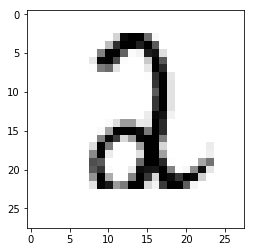

In [3]:
# load MNIST:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

# 
sample_image = mnist.train.next_batch(1)[0]
# the shape is a row on 784:
print(sample_image.shape)
#%% 


#%% 
# standadize the image size and take a look:
sample_image = sample_image.reshape([28, 28])
# imshow will visuzliae the scalar 2D images once those are reshaped from 784X1
# to 28X28:
plt.imshow(sample_image, cmap='Greys')
#%% 


In [4]:
# D:
# D is a classic feedforward CNN. This network is built from two convolutional
#  layers and two fully connected layers. Pooling is used:

def discriminator(images, reuse=False):
    if (reuse):
        # reuse=tf.AUTO_REUSE
        # The function reuse_variables() will always produce None as a result. 
        # Its only function is to set the attribute reuse of the current scope to True.
        # get_variable_scope() returns current variable scope.
        tf.get_variable_scope().reuse_variables()
    # First convolutional and pool layers
    # This finds 32 different 5 x 5 pixel features
    # initializer=tf.truncated_normal_initializer: Initializer that generates a truncated normal distribution:
    # get_variable either creates or gets the required variable:
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    # as far as I can tell, choosing stddev here is tuning more than hard code science.
    # Initializer that generates tensors with constant values for the bias:
    d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))

    # tf.nn.conv2d  - Computes a 2-D convolution given 4-D input and filter tensors.
    d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
    # adding the bias:
    d1 = d1 + d_b1
    # activation:
    d1 = tf.nn.relu(d1)
    # Performs the average pooling on the input:
    # average pooling takes the average of the pixels within the window defined:
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')



    # Second convolutional and pool layers
    # This finds 64 different 5 x 5 pixel features
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # First fully connected layer
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    # matmul = matrix multiplication:
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = tf.nn.relu(d3)

    # Second fully connected layer
    d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
    d4 = tf.matmul(d3, d_w4) + d_b4

    # d4 contains unscaled values
    print("finished with D")
    return d4

In [5]:
print("D has been defined!")


D has been defined!


In [25]:
# G:
def generator(z, batch_size, z_dim):
    # takes random values, the batchsize and zdim would be the numver of coloumns.
    # batch_size is essentially the number of images produced.
    # z_dim is num of random values per image produced.
    # first layer takes noise + vlaues, batchnorm and ReLus:
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # the rest is 3 convolutions, which will flash out high-level features:

    # Generate 50 features
    # second layer  - convolutions:
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    # batchnorm:
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    # scale back to original size:
    g2 = tf.nn.relu(g2)
    # turning back to original size:
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    # squeeze values either way (i.e. pixels to be black or white)
    g4 = tf.sigmoid(g4)

    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

In [26]:
print("G has been defined!")


G has been defined!


In [27]:
z_dimensions = 100
# initiate a placeholder with random values:
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])
#%% 

#%% 
generated_image_output = generator(z_placeholder, 1, z_dimensions)
# initiate a matrix with random values:
z_batch = np.random.normal(0, 1, [1, z_dimensions])
#%% 


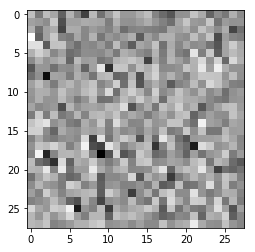

In [28]:
# Test G: generate a random image:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')



In [29]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

print("placeholders defined!")


placeholders defined!


In [30]:
Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

# with tf.variable_scope(tf.get_variable_scope()) as scope:
#     pass 

# with tf.variable_scope(tf.get_variable_scope()) as vscope:
#     tf.get_variable_scope().reuse_variables()     # HERE

# with tf.variable_scope("discriminator") as scope:
#     scope.reuse_variables()

# with tf.variable_scope("generator") as scope: 
#     scope.reuse_variables()

with tf.variable_scope(tf.get_variable_scope(), reuse=False) as scope:
    assert tf.get_variable_scope().reuse == True



Dg = discriminator(Gz, reuse=True)
# Dg will hold discriminator prediction probabilities for generated images.


AssertionError: 

In [20]:
# loss funcs for D:
# cross entropy loss
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Dx, logits=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Dg, logits=tf.zeros_like(Dg)))
#%% 


#%% 
# loss for the generator:
# the loss is of course the opposite to the d_loss_fake since it's a minmax game (g is maximizing 
# what d is trying to minimize, i.e. fake pics classified as real).
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Dg, logits=tf.ones_like(Dg)))


In [21]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


In [22]:
# Train the discriminator
# tf.train.AdamOptimizer
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)


ValueError: Variable d_w1/Adam_2/ does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=tf.AUTO_REUSE in VarScope?

In [23]:
"""
This is a straightforward Python implementation of a generative adversarial network.
The code is derived from the O'Reilly interactive tutorial on GANs
(https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners).
The tutorial's code trades efficiency for clarity in explaining how GANs function;
this script refactors a few things to improve performance, especially on GPU machines.
In particular, it uses a TensorFlow operation to generate random z values and pass them
to the generator; this way, more computations are contained entirely within the
TensorFlow graph.
A version of this model with explanatory notes is also available on GitHub
at https://github.com/jonbruner/generative-adversarial-networks.
This script requires TensorFlow and its dependencies in order to run. Please see
the readme for guidance on installing TensorFlow.
This script won't print summary statistics in the terminal during training;
track progress and see sample images in TensorBoard.
"""

import tensorflow as tf
import datetime

# Load MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

# Define the discriminator network
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

# Define the generator network
def generator(batch_size, z_dim):
    z = tf.random_normal([batch_size, z_dim], mean=0, stddev=1, name='z')
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='g_b1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='g_b2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='g_b3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

z_dimensions = 100
batch_size = 50

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder')
# x_placeholder is for feeding input images to the discriminator

Gz = generator(batch_size, z_dimensions)
# Gz holds the generated images

Dx = discriminator(x_placeholder)
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

# Define losses
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

# Define variable lists
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

# Define the optimizers
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


ValueError: Variable g_b1/beta does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=tf.AUTO_REUSE in VarScope?